In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

In [16]:
#Parameters for DCNs

Ns=1000   #Size of the DCNs：1000μm*1000μm
lam = 0.8465 #wavelength
Dx=5     #Neuron size: 5μm, must be divisible by Ns

VCSEL_size=np.array([8,8],dtype=int)   #Scale of the VCSEL array
num=VCSEL_size[0]*VCSEL_size[1]   #number of the VCSELs

z=np.array([[963, 1, 1], 
            [1020, 1.4526, 1],
            [5000, 1, 0]
           ])
#Define the light propagation parameters: 
#[propagation distance (μm), medium refractive index, whether there is  a diffractive layer after propagation (yes: 1 or not: 0)]


#Parameters for the datasets
n_types=np.array([0,1,2,3,4,5,6,7,8,9]) #The digits to be recognized, ranging from 0 to 9
n_train=50  #The number of training set images for each class. The total number of training set images equals n_train*n_types
n_test=10    #The number of test set images for each class. The total number of test set images equals n_test*n_types

#训练参数
n_epochs = 100
learning_rate = 0.006

In [17]:
#Read the original MNIST dataset
from tensorflow import keras
fashion_mnist=keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


#Or Read the original EMNIST dataset
#import idx2numpy
#train_images = idx2numpy.convert_from_file('./emnist-letters-train-images-idx3-ubyte')
#train_labels = idx2numpy.convert_from_file('./emnist-letters-train-labels-idx1-ubyte')
#test_images = idx2numpy.convert_from_file('./emnist-letters-test-images-idx3-ubyte')
#test_labels = idx2numpy.convert_from_file('./emnist-letters-test-labels-idx1-ubyte')

In [18]:
#Adjust the dataset images according to the training parameters
def changeMnist(n_types,n_images,train_dataset,label_dataset,VCSEL_size):  
    #(Number of recognition classes, number of images per class, original dataset, label, and target image size)
    count=np.zeros([10,1])
    m = train_dataset.shape[0]
    n = n_types.shape[0]
    Nx=VCSEL_size[0]+2
    Ny=VCSEL_size[1]+2
    resize_train_dataset=[]
    resize_label_dataset=[]
    #N=int(Ns*0.6)
    #Dt=int((Ns-N)/2)
    for i in range(m):
        y1=np.zeros(VCSEL_size)
        for j in range(n):
            if (n_types[j]==label_dataset[i]) and (count[j,0]<n_images):
                #y=np.array(Image.fromarray(train_dataset[i,:,:].reshape(28,28)).resize((N,N)))
                y=np.array(Image.fromarray(train_dataset[i,:,:].reshape(28,28)).resize((Nx,Ny)))
                y1=y[1:(1+VCSEL_size[0]),1:(1+VCSEL_size[1])]
                resize_train_dataset.append(y1)
                resize_label_dataset.append(j)
                count[j]=count[j]+1
    return resize_train_dataset,resize_label_dataset

In [19]:
#Training set, test set image preprocessing
x_train,y_train=changeMnist(n_types,n_train,train_images,train_labels,VCSEL_size)
x_test,y_test=changeMnist(n_types,n_test,test_images,test_labels,VCSEL_size)
x_train=np.array(x_train,dtype=np.float32)
y_train=np.array(y_train,dtype=np.float32)

x_test=np.array(x_test,dtype=np.float32)
y_test=np.array(y_test,dtype=np.float32)

m=x_train.shape[0]
mt=x_test.shape[0]


#Image binarization + normalization
def binary_image(x):
    a=x.shape[0]
    for i in range(a):
        exist=np.count_nonzero(x[i])
        mean_value = x[i].sum()/exist
        x[i][x[i]>mean_value]=255
        x[i][x[i]<=mean_value]=0
    return x

x_train=binary_image(x_train)
x_test=binary_image(x_test)
x_train=x_train/255
x_test=x_test/255

x_train=x_train.reshape([m,num])
x_test=x_test.reshape([mt,num])

In [20]:
#Clear the original training set and test set to avoid occupying memory
del train_images, train_labels, test_images, test_labels

In [21]:
#Generating the input light field for each VCSEL unit

#Read the calculated amplitude distribution of LP01 mode
amplitude = pd.read_csv("amplitude _Gaussian.csv",delimiter=',',header=None,engine='c',na_filter=False,dtype=np.float32,low_memory=False)

amplitude1=amplitude/255

VCSEL = np.zeros((num,Ns,Ns),dtype=float)

i=0
Na=int(Ns/2-50*VCSEL_size[0]+50) #起始坐标x
Nb=int(Ns/2-50*VCSEL_size[1]+50) #起始坐标y

for a in range(VCSEL_size[0]): 
    for b in range(VCSEL_size[1]):
        x1=Na+100*(a)-4
        x2=Na+100*(a)+6
        y1=Nb+100*(b)-4
        y2=Nb+100*(b)+6
        VCSEL[i,x1:x2,y1:y2]=amplitude1
        i=i+1

In [22]:
#Tensorflow training: Angular Diffraction
def Propogation(E,Ns,λ,z1,n):  #light field, Size, wavelength, propagation distance, refrective index
    
    Nx = Ns             
    dx = 1            
    lam =λ/n          
    z = z1              
#    T_Field = {}
    fx = np.fft.fftshift(np.fft.fftfreq(Nx, d = dx))
    fxx, fyy = np.meshgrid(fx, fx)
    argument = (2 * np.pi)**2 * ((1. / lam) ** 2 - fxx ** 2 - fyy ** 2)

    #Calculate the propagating and the evanescent (complex) modes
    tmp = np.sqrt(np.abs(argument))
    kz = np.where(argument >= 0, tmp, 1j*tmp)
    # compute angular spectrum

    fft_c = tf.signal.fft2d(E)
    c = tf.signal.fftshift(fft_c)
        # propagate the angular spectrum a distance z
    Field = tf.signal.ifft2d(tf.signal.ifftshift(c * np.exp(1j * kz * z)))
    
    return Field

#Tensorflow training: Amplitude superposition of the light fields of the VCSELs
def Total_Amp_Field(E):
    E=tf.reduce_sum(tf.abs(E),axis=0)
    return E

In [23]:
#numpy: Angular Diffraction
def Propogation_1(E,Ns,λ,z1,n):  #light field, Size, wavelength, propagation distance, refrective index
    
    Nx = Ns             
    dx = 1            
    lam =λ/n          
    z = z1              
#    T_Field = {}
    fx = np.fft.fftshift(np.fft.fftfreq(Nx, d = dx))
    fxx, fyy = np.meshgrid(fx, fx)
    argument = (2 * np.pi)**2 * ((1. / lam) ** 2 - fxx ** 2 - fyy ** 2)

    #Calculate the propagating and the evanescent (complex) modes
    tmp = np.sqrt(np.abs(argument))
    kz = np.where(argument >= 0, tmp, 1j*tmp)
    kz = np.exp(1j * kz * z)

    fft_c = np.fft.fft2(E)
    c = np.fft.fftshift(fft_c)

    # propagate the angular spectrum a distance z
    return np.fft.ifft2(np.fft.ifftshift(c * kz))

#numpy: : Amplitude superposition of the light fields of the VCSELs
def Total_Amp_Field1(E):
    E=np.abs(E)
    return np.sum(E,axis=0)

9.0


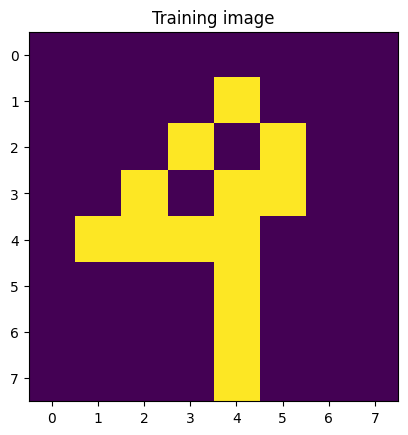

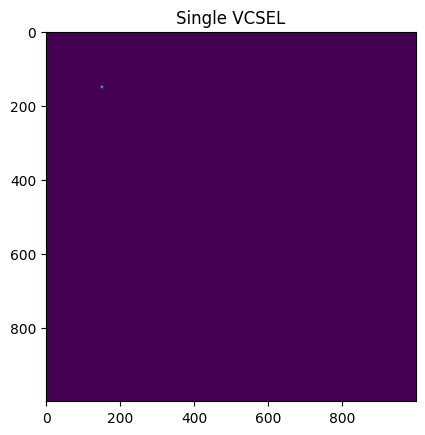

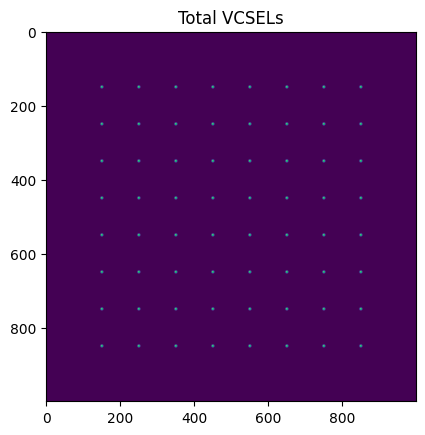

In [24]:
#Validation the training set images
t=4
print(y_train[t])
plt.figure()
plt.imshow(x_train[t].reshape(VCSEL_size))
plt.title('Training image')
plt.show()

# Verify the input light field of a VCSEL unit
plt.figure()
plt.imshow(np.abs(VCSEL[0]))
plt.title('Single VCSEL')
plt.show()

# Verify the input light fields of all VCSELs
V=Total_Amp_Field1(VCSEL)
plt.figure()
plt.imshow(V)
plt.title('Total VCSELs')
plt.show()

In [25]:
#Calculate the light field of on first diffractive layer
VCSEL_after_diffraction = Propogation_1(VCSEL,Ns,lam,z[0,0],z[0,1])

(64, 1000, 1000)


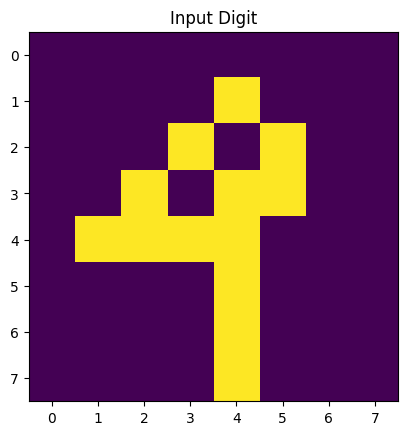

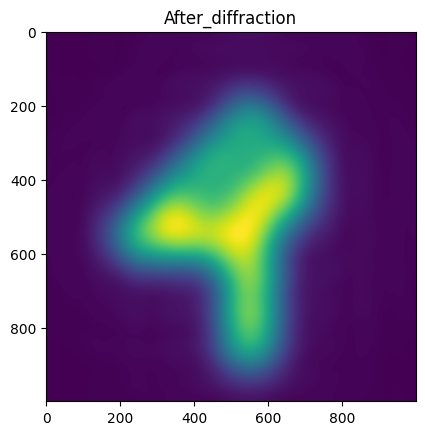

In [26]:
#Verify the light field after propagation
print(VCSEL_after_diffraction.shape)
test_input = x_train[t]
plt.imshow(test_input.reshape(VCSEL_size))
plt.title('Input Digit')
plt.show()
#test_output = []

test_output = np.zeros((num,Ns,Ns),dtype=complex)
for i in range(0,num):
    test_output[i,:,:]=test_input[i]*VCSEL_after_diffraction[i,:,:]

test_output1 = Total_Amp_Field1(test_output)
#test_output1 = np.sum(test_output,axis=0)
plt.imshow(np.abs(test_output1))
plt.title('After_diffraction')
plt.show()

(1, 1000, 1000)
(1000000, 10)
1.0


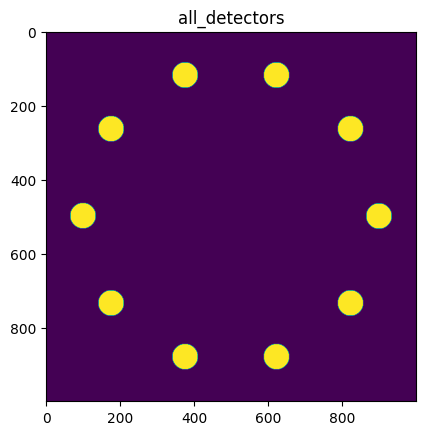

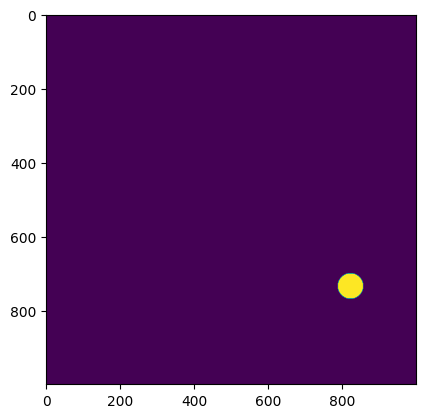

In [27]:
#define the detection regions

#（distribution='Uniform'）or（distribution='Gaussian'）
def detector_region(Ns,R,r,n,distribution='Uniform',template='Excluding background'):  
    #R: Detector distribution radius, r: Radius of each detection region, n: number of detection regions
    area=np.zeros([2*r,2*r])
    for x in range(2*r):
        for y in range(2*r):
            if ((x-r+0.5)**2+(y-r+0.5)**2)<=(r-0.5)**2:
                if distribution=='Uniform':
                    area[x,y]=1.0
                if distribution=='Gaussian':
                    sigma=15 #调节高斯分布模型
                    area[x,y]=np.exp((-(x-r+0.5)**2-(y-r+0.5)**2)/2/sigma**2)
    area=area/np.max(area)
    Geshu2=n
    peak=[]
    for t in range(Geshu2):
        theta = t*(2*np.pi/Geshu2)
        x0 = int(Ns/2); y0 = x0
        x = x0+ R*np.cos(theta+np.pi/Geshu2)
        y = y0+ R*np.sin(theta+np.pi/Geshu2)
        peak.append([int(x),int(y)])
    if template=='Excluding background':
        d=np.zeros([Ns**2,Geshu2])
        for i in range(Geshu2):
            b=np.zeros([Ns,Ns])
            order=peak[i]
            x=order[0]; y=order[1]
            b[x-r:x+r,y-r:y+r]=area
            d[:,i:i+1]=np.reshape(b,[Ns**2,1])
        all_d=d.sum(axis=1)
    if template=='Including background':
        d=np.zeros([Ns**2,Geshu2+1])
        background=np.ones([Ns**2,1],dtype=float)
        for i in range(Geshu2):
            b=np.zeros([Ns,Ns])
            order=peak[i]
            x=order[0]; y=order[1]
            b[x-r:x+r,y-r:y+r]=area
            d[:,i:i+1]=np.reshape(b,[Ns**2,1])
        all_detectors=d.sum(axis=1)
        background=background-all_detectors.reshape(Ns**2,1)
        d[:,Geshu2:Geshu2+1]=background*0.05
        all_d=d[:,0:Geshu2].sum(axis=1)
    return d,all_d.reshape(1,Ns,Ns)


detector_template,all_detectors=detector_region(Ns,400,35,n_types.shape[0])

print(all_detectors.shape)
print(detector_template.shape)
print(np.max(detector_template))

plt.imshow(all_detectors[0])
plt.title('all_detectors')
plt.show()

detector_template[:,1]=detector_template[:,1]*1
plt.imshow(detector_template[:,1].reshape(Ns,Ns))
plt.show()#DCNs training based on tensorflow framework

In [ ]:
#DCNs training based on tensorflow framework
NL=0
for i in range(z.shape[0]):
    if z[i,2]==1:
        NL=NL+1
batch_size = 1 #batch_size should be 1

#Training parameters
n_batches = int(np.ceil(m / batch_size))
#tf.reset_default_graph()
tf.compat.v1.reset_default_graph()
# Construct Tensorflow Graph
tf.compat.v1.disable_eager_execution()
inputs = tf.compat.v1.placeholder(tf.complex64, shape=(batch_size, num), name='inputs')  # input test cases
labels = tf.compat.v1.placeholder(tf.int32, shape=(batch_size,), name='labels')  # labels for test cases
d = tf.constant(detector_template, dtype=tf.float32, name='detectors')  # 10 x N**2
all_d = tf.constant(all_detectors, dtype=tf.float32, name='all_detectors')  # 1 x N**2
VCSEL_after_diffraction1 = tf.constant(VCSEL_after_diffraction, dtype=tf.complex64, name='VCSEL_after_diffraction')
# Input layer

def diffraction_layer(X,Dx):
    # Complex amplitude + phase of optical waves
    #a = tf.Variable(tf.constant(1, shape=[1, N, N], dtype=tf.float32), name='alpha')
    #t = tf.Variable(tf.compat.v1.random_normal([1,int(Ns/Dx),int(Ns/Dx)], dtype=tf.float32)) 
    t = tf.Variable(tf.constant(0, shape=[1, int(Ns/Dx), int(Ns/Dx)], dtype=tf.float32), name='theta') 
    t1=tf.repeat(t,Dx,axis=1)
    t2=tf.repeat(t1,Dx,axis=2)
    pi = tf.constant(math.pi, dtype=tf.float32)
    theta = 2 * pi * t2  # phase in exp(j*theta)
    phase_mod = tf.complex(tf.cos(theta), tf.sin(theta), name='phase_mod')
    #phase_mod = tf.math.exp(1j*tf.cast(theta,dtype=tf.complex64))
    #a_mod = tf.nn.relu(a) / tf.reduce_max(tf.nn.relu(a))
    #amp_mod = tf.cast(a_mod, dtype=tf.complex64, name='amp_mod')
    #com_mod = tf.multiply(amp_mod, phase_mod, name='com_mod')
    layer = X * tf.tile(phase_mod, [num, 1 , 1])  # BS x N**2
    return layer


# 衍射层传播过程
#inputs1=tf.transpose(inputs)
inputs1=tf.reshape(inputs,[num,1,1])
Feild=tf.multiply(inputs1, VCSEL_after_diffraction1)


for i in range(z.shape[0]-1):
    if z[i,2]==1:
        Feild = diffraction_layer(Feild,Dx)
    Feild=Propogation(Feild,Ns,lam,z[i+1,0],z[i+1,1])

#outputsf=tf.reshape(Feild, [num,Ns*Ns])

outputsf=Total_Amp_Field(Feild)
# Photodetectors
outputs_mask = outputsf * all_d


def normalize_output(A):
    m0, n0 = A.shape
    norm = tf.tile(tf.reshape(tf.reduce_max(A, axis=1), [m0, 1]), [1, n0])
    norm_A = tf.square(A / norm)
    return norm_A

# Cross Entropy
outputsf=tf.reshape(outputsf, [batch_size,Ns*Ns])
out = tf.matmul(tf.abs(outputsf), d)  # only sum over detectors
out_norm = normalize_output(out)
sm = tf.nn.softmax(logits=out_norm, name='soft_max')
#loss=tf.reduce_mean((tf.square(sm-labels)))
xent = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=out_norm)
loss = tf.reduce_mean(xent, name='loss')
# Optimizer
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
# optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)


optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

training_op = optimizer.minimize(loss)

# Mini-Batch Gradient Descent
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = x_train[indices,]
    y_batch = y_train[indices,]
    return X_batch, y_batch

init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

# Summary
loss_summary = tf.compat.v1.summary.scalar('Loss', loss)
file_writer = tf.compat.v1.summary.FileWriter("tf_logs", tf.compat.v1.get_default_graph())

# Session
with tf.compat.v1.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        epoch_loss = 0  # reset loss
        test_softmax = np.empty((m,detector_template.shape[1]))
        
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)

            if batch_index % 100 == 0:
                summary_str = loss_summary.eval(feed_dict={inputs: X_batch, labels: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            
            batch_loss = sess.run([training_op, loss], feed_dict={inputs: X_batch, labels: y_batch})
            #print(batch_loss)
            epoch_loss += batch_loss[1]
        
        for batch_index in range(n_batches):    
            start_ind = batch_index*batch_size
            end_ind = start_ind + batch_size
            test_softmax[start_ind:end_ind,:] = sm.eval(feed_dict={inputs: x_train[start_ind:end_ind,:]})
        Y_pred = test_softmax
        Y_pred_classes = np.argmax(Y_pred, axis = 1)
        errors = (Y_pred_classes - y_train != 0)
        acc = 1 - np.count_nonzero(errors)/m
                    
        print("Epoch：", epoch, "Loss =",
              epoch_loss / n_batches)  # print out loss averaged over all batches
        print("Epoch：", epoch,'Training Accuracy = {a:8.2f} %'.format(a=100*acc))
        save_path = saver.save(sess, "tmp/my_model.ckpt")
            

    save_path = saver.save(sess, "tmp/my_model_final.ckpt")

    # Sample Results From Mini-batch
    test_input = X_batch
    test_labels = y_batch
    test_softmax, test_output, test_mask, test_logits = sess.run([sm, outputsf, outputs_mask, out_norm],
                                                                 feed_dict={inputs: X_batch, labels: y_batch})
    
    c=[]
    # Complex Modulation
    if NL==1:
        c.append(sess.run([tf.compat.v1.get_default_graph().get_tensor_by_name("phase_mod:0")]))
    if NL>1:
        c.append(sess.run([tf.compat.v1.get_default_graph().get_tensor_by_name("phase_mod:0")]))
        for i in range(NL-1):
            c.append(sess.run([tf.compat.v1.get_default_graph().get_tensor_by_name("phase_mod_"+str(i+1)+":0")]))

file_writer.close()

In [ ]:
# Show one set of training results
plt.figure(figsize=((8,180)))
plt.subplot(1,3,1)
plt.imshow(np.abs(test_input).reshape(VCSEL_size))
plt.title('Input Digits')
plt.subplot(1,3,2)
plt.imshow(np.abs(test_output).reshape((batch_size*Ns,Ns)))
plt.title('Output Pattern')
plt.subplot(1,3,3)
plt.imshow(np.abs(test_mask).reshape((batch_size*Ns,Ns)))
plt.title('Photodetectors')
plt.show()

print(test_labels)
print(np.argmax(test_softmax,axis=1))

In [ ]:
# Displaying the phase distribution of DCNs

c1=np.array(c,dtype=complex)
print(np.min(np.abs(c1[0].reshape(Ns,Ns))))
print(np.max(np.abs(c1[0].reshape(Ns,Ns))))
print(c1.shape)

def amp_phase(c):
    return np.abs(c),np.angle(c)

fig, ax = plt.subplots(NL,2,figsize=((10,4*NL)))

ax=ax.reshape([NL,2])

for ind,c2 in enumerate((c1)):
    A,P = amp_phase(c2)
    im = ax[ind,0].imshow(A.reshape((Ns,Ns)))
    fig.colorbar(im,ax=ax[ind,0])
    im = ax[ind,1].imshow(P.reshape((Ns,Ns)))
    fig.colorbar(im,ax=ax[ind,1])

plt.show()

In [ ]:
#Save the phase distributions of DCNs

def save_a(obj,name):
    obj1=(np.angle(obj)+np.pi)/2/np.pi*255
    obj2=Image.fromarray(np.array(obj1,dtype='uint8'))
    obj2.save(r'C:\Users\DELL\Desktop\{}.bmp'.format(name))
    
for i in range(NL):
    save_a(c1[i].reshape(Ns,Ns), 'phi'+str(i+1))